# Credit Card Analysis Assessment

##### Create a pyspark session
##### Read from json file

In [447]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("JSON Reader").getOrCreate()

df = spark.read.json("data/cc_sample_transaction.json")

##### Step 3a Parsing personal details

In [448]:
from pyspark.sql.functions import col, from_json, split
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, TimestampType

personal_detail_schema = StructType([
    StructField("person_name", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("address", StringType(), True),
    StructField("lat", StringType(), True),
    StructField("long", StringType(), True),
    StructField("city_pop", StringType(), True),
    StructField("job", StringType(), True),
    StructField("dob", StringType(), True)
])

# Name derivation
###### Parse personal_detail as Struct
###### Split person_name into first and last
###### ! Need to split this to explain further
###### Initially thought that each person's name is split by an empty space, further analysis shows it could be any delimiter
###### Split based on regex
###### For example, some of the names were added with NOOOO in the dirty data, using this alphabetical regex split and only getting the first and second items seem to solve this
###### The rest is pretty straight-forward

In [449]:
df = df.withColumn("personal_detail", from_json("personal_detail", personal_detail_schema))

df = df.withColumn("first", split(col("personal_detail.person_name"), "[^A-Za-z]+").getItem(0))
df = df.withColumn("last", split(col("personal_detail.person_name"), "[^A-Za-z]+").getItem(1))

df = df.withColumn("gender", col("personal_detail.gender"))
df = df.withColumn("city_pop", col("personal_detail.city_pop"))
df = df.withColumn("job", col("personal_detail.job"))
df = df.withColumn("dob", col("personal_detail.dob"))
df = df.withColumn("lat", col("personal_detail.lat"))
df = df.withColumn("long", col("personal_detail.long"))

Step 3b Parse address into street, city, state, zip

In [450]:
address_schema = StructType([
    StructField("street", StringType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("zip", StringType(), True)
])

Extract the rest of the details from address struct.

In [451]:
df = df.withColumn("address", from_json(col("personal_detail.address"), address_schema))

df = df.withColumn("street", col("address.street"))
df = df.withColumn("city", col("address.city"))
df = df.withColumn("state", col("address.state"))
df = df.withColumn("zip", col("address.zip"))

Step 3c Convert timestamps to human-readable format in UTC+8

Because I'm given two types of epoch time, 13 and 16 digits length, which are milli and microseconds respectively.
So use an if statement to check how long before dividing.

Previously I thought that the epoch time given is utc time, so I used the from_utc_timestamp to convert, but it's actually local time utc+8, so I can skip doing another conversion.

In [452]:
from pyspark.sql.functions import from_utc_timestamp, from_unixtime, col, date_format, expr

df = df.withColumn("trans_date_trans_time", date_format(from_utc_timestamp(col("trans_date_trans_time"), "Asia/Singapore"), "yyyy-MM-dd HH:mm"))

df = df.withColumn(
    "merch_last_update_time",
    date_format(
        from_unixtime(expr("merch_last_update_time / (IF(LENGTH(merch_last_update_time) = 16, 1000000, 1000))")),
        "yyyy-MM-dd HH:mm"
    )
)

df = df.withColumn(
    "merch_eff_time",
    date_format(
        from_unixtime(expr("merch_eff_time / (IF(LENGTH(merch_eff_time) = 16, 1000000, 1000))")),
        "yyyy-MM-dd HH:mm"
    )
)

##### Step 3d Drop unnecessary columns
Since there are only used as a placeholder for struct data

In [453]:
df = df.drop("personal_detail", "address")

Step 4: Check for data inconsistencies

##### Check missing or null values
##### Check inconsistent format
##### Check categorical value
##### Check duplicate row


In [454]:
from pyspark.sql.functions import col, upper

# Get all column names
columns_to_check = ["first", "last", "cc_num", "amt", "trans_date_trans_time", "merch_last_update_time", "merch_eff_time"]

# Build the filter condition dynamically for null, empty, "N/A", "NA" and "None"
condition = None
for c in columns_to_check:
    col_condition = (
        col(c).isNull() |  # Check for null values
        (col(c) == "") |  # Check for empty strings
        (upper(col(c)) == "N/A") |  # Check for "N/A" (case-insensitive)
        (upper(col(c)) == "NA") |  # Check for "NA" (case-insensitive)
        (upper(col(c)) == "NONE")  # Check for "None" (case-insensitive)
    )
    condition = col_condition if condition is None else condition | col_condition

# Apply the filter to find dirty rows
dirty_rows = df.filter(condition)

# Show the dirty rows (or you can save it, analyze, etc.)
dirty_rows.show(truncate=False)
print(f"There is {dirty_rows.count()} rows with empty values.")


+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+-----+----+------+--------+---+---+---+----+------+----+-----+---+
|Unnamed: 0|amt|category|cc_bic|cc_num|is_fraud|merch_eff_time|merch_last_update_time|merch_lat|merch_long|merch_zipcode|merchant|trans_date_trans_time|trans_num|first|last|gender|city_pop|job|dob|lat|long|street|city|state|zip|
+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+-----+----+------+--------+---+---+---+----+------+----+-----+---+
+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+-----+----+------+--------+---+---+---+----+------+----+-----+---+



There is 0 rows with empty values.


In [455]:
time_columns = ["trans_date_trans_time", "merch_last_update_time", "merch_eff_time"]

condition = None

# Regex pattern for yyyy-MM-dd HH:mm
time_format_regex = r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}$'

# Loop through each time column
for c in time_columns:
    col_condition = ~col(c).rlike(time_format_regex)  # Check for invalid format
    condition = col_condition if condition is None else condition | col_condition
    
invalid_time_rows = df.filter(condition)
invalid_time_rows.show(truncate=False)

print(f"There is {invalid_time_rows.count()} invalid time rows.")

+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+-----+----+------+--------+---+---+---+----+------+----+-----+---+
|Unnamed: 0|amt|category|cc_bic|cc_num|is_fraud|merch_eff_time|merch_last_update_time|merch_lat|merch_long|merch_zipcode|merchant|trans_date_trans_time|trans_num|first|last|gender|city_pop|job|dob|lat|long|street|city|state|zip|
+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+-----+----+------+--------+---+---+---+----+------+----+-----+---+
+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+-----+----+------+--------+---+---+---+----+------+----+-----+---+



There is 0 invalid time rows.


In [456]:
invalid_gender_rows = df.filter(~col("gender").isin(["M", "F"]))

# Show the result
invalid_gender_rows.show(truncate=False)
print(f"There is {invalid_gender_rows.count()} rows with invalid gender.")

+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+-----+----+------+--------+---+---+---+----+------+----+-----+---+
|Unnamed: 0|amt|category|cc_bic|cc_num|is_fraud|merch_eff_time|merch_last_update_time|merch_lat|merch_long|merch_zipcode|merchant|trans_date_trans_time|trans_num|first|last|gender|city_pop|job|dob|lat|long|street|city|state|zip|
+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+-----+----+------+--------+---+---+---+----+------+----+-----+---+
+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+-----+----+------+--------+---+---+---+----+------+----+-----+---+



There is 0 rows with invalid gender.


# Hashing

#### Opt to use sha hashing, for several reasons:
- Don't need to retrieve original values
- Only need the data for analysis
- Able to match records without exposing sensitive info

In [457]:
from pyspark.sql.functions import sha2

pii_columns = ["cc_num", "first", "last", "street", "city", "state", "zip"]
for col in pii_columns:
    df = df.withColumn(col, sha2(col, 256))
    
df.show(5)


+----------+------+-------------+-----------+--------------------+--------+----------------+----------------------+------------------+-----------+-------------+--------------------+---------------------+--------------------+--------------------+--------------------+------+--------+--------------------+----------+-------+---------+--------------------+--------------------+--------------------+--------------------+
|Unnamed: 0|   amt|     category|     cc_bic|              cc_num|is_fraud|  merch_eff_time|merch_last_update_time|         merch_lat| merch_long|merch_zipcode|            merchant|trans_date_trans_time|           trans_num|               first|                last|gender|city_pop|                 job|       dob|    lat|     long|              street|                city|               state|                 zip|
+----------+------+-------------+-----------+--------------------+--------+----------------+----------------------+------------------+-----------+-------------+------

Step 8: Visualization

Now the fun part. What can we know from these data?

Number of fraud cases from this credit card sample is 7506, which is 0.579% of all 1296675 transactions.

In [472]:
fraud_df = df.filter(df["is_fraud"] == 1)

import pandas as pd
rows = fraud_df.collect()

# Convert to Pandas DataFrame
fraud_df_pandas = pd.DataFrame([row.asDict() for row in rows])

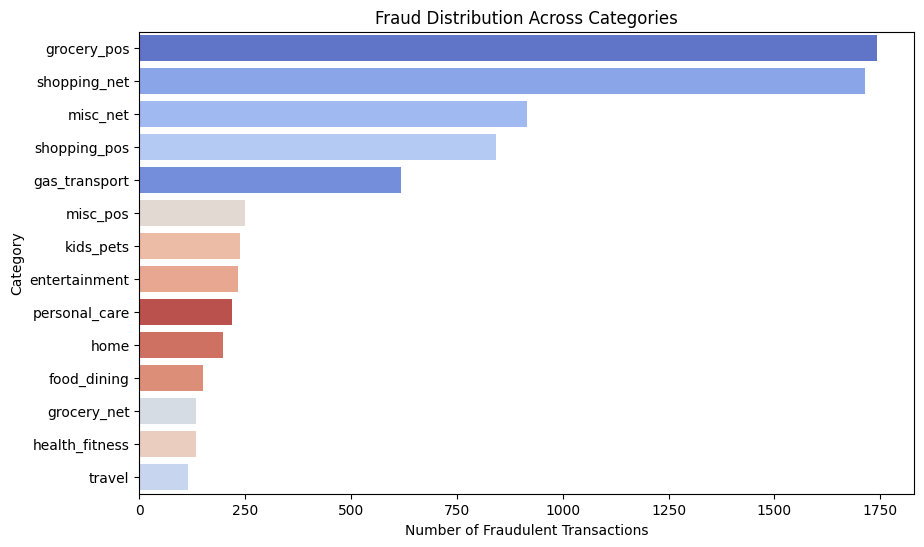

In [473]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(
    data=fraud_df_pandas,
    y='category',
    order=fraud_df_pandas['category'].value_counts().index,
    hue='category',
    palette='coolwarm'
)
plt.title('Fraud Distribution Across Categories')
plt.xlabel('Number of Fraudulent Transactions')
plt.ylabel('Category')
plt.show()

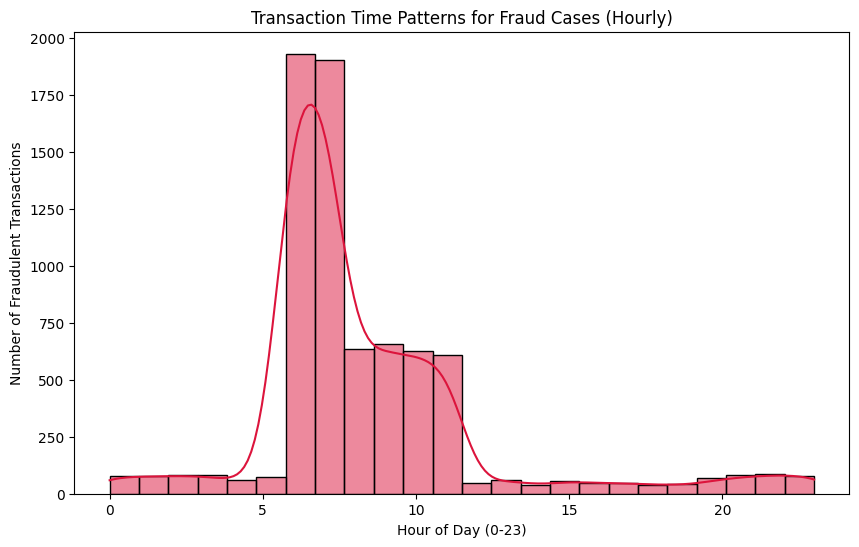

In [483]:
fraud_df_pandas['trans_date_trans_time'] = pd.to_datetime(fraud_df_pandas['trans_date_trans_time'])
fraud_df_pandas['hour'] = fraud_df_pandas['trans_date_trans_time'].dt.hour

# Plot histogram of transaction times for fraud cases
plt.figure(figsize=(10, 6))
sns.histplot(fraud_df_pandas['hour'], bins=24, kde=True, color='crimson')
plt.title('Transaction Time Patterns for Fraud Cases (Hourly)')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()